# Background



While ETFs do provide low-cost access to a variety of asset classes, industry sectors, and international markets, they do carry some unique risks. For e.g. trading fees and lack of liquidity. We shall explore research-backed techniques of portfolio diversification as an possible alternative to ETF-investing.

In this notebook, several portfolio optimization techniques are used to find the best portfolio-allocation strategy. The objective is to **employ well-documented portfolio-management methods as a retail investor.**

# Input Libraries and Data

In [191]:
import yfinance as yf
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.objective_functions import L2_reg
from fastquant import backtest
from fastquant import get_stock_data

import pandas as pd
import numpy as np
import time
import json
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import scipy.optimize as sco

np.random.seed(777)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
%config InlineBackend.figure_format = 'retina'

In [218]:
tickers = ['TSLA', 'ARKK', 'AAPL']
# tickers = ['TSLA', 'GOOG', 'AAPL',]

df_all = pd.DataFrame()
for ticker in tickers:
    # download adjusted closing prices from yahoo finance
    data = yf.download(ticker,'2015-01-01','2020-11-01')['Adj Close']
    df_all[f'{ticker}_adj_close'] = data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [219]:
df = df_all.loc[:'2019-12-31']

# UDF

In [220]:
def plot_daily_adj_returns(df):
    plt.figure(figsize=(14, 7))
    for c in df.columns.values:
        plt.plot(df.index, df[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=12)
    plt.ylabel('price in $')
    
def plot_daily_adj_returns_perc_change(df):
    returns = df.pct_change()
    plt.figure(figsize=(14, 7))
    for c in returns.columns.values:
        plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper right', fontsize=12)
    plt.ylabel('daily returns')

# Preliminary Analysis

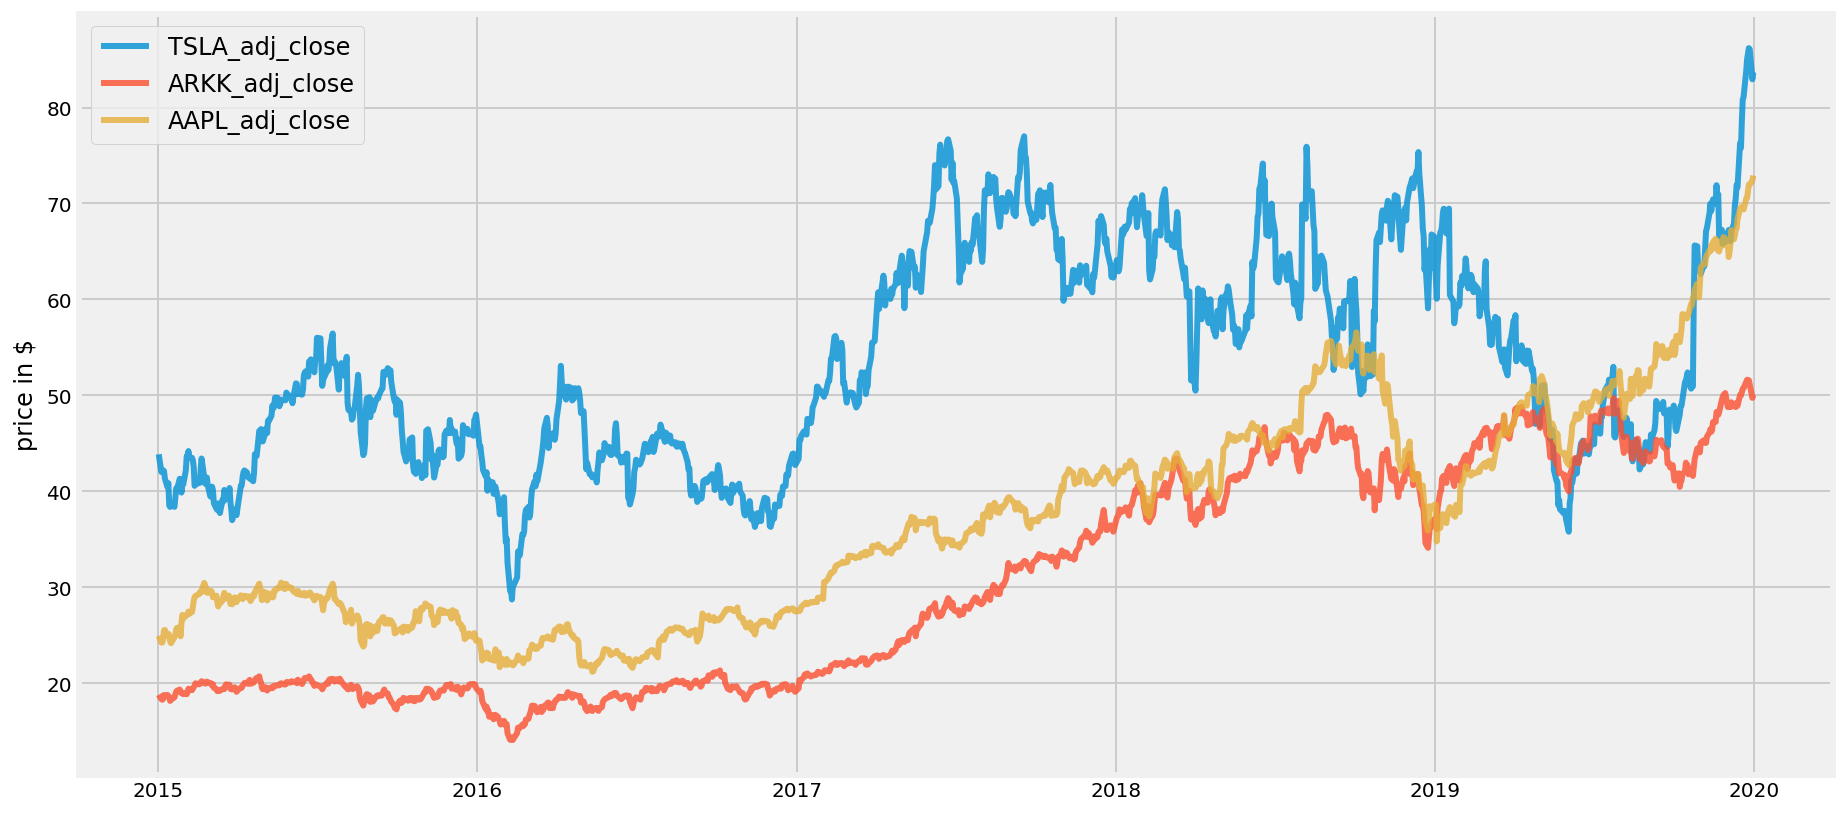

In [221]:
plot_daily_adj_returns(df)

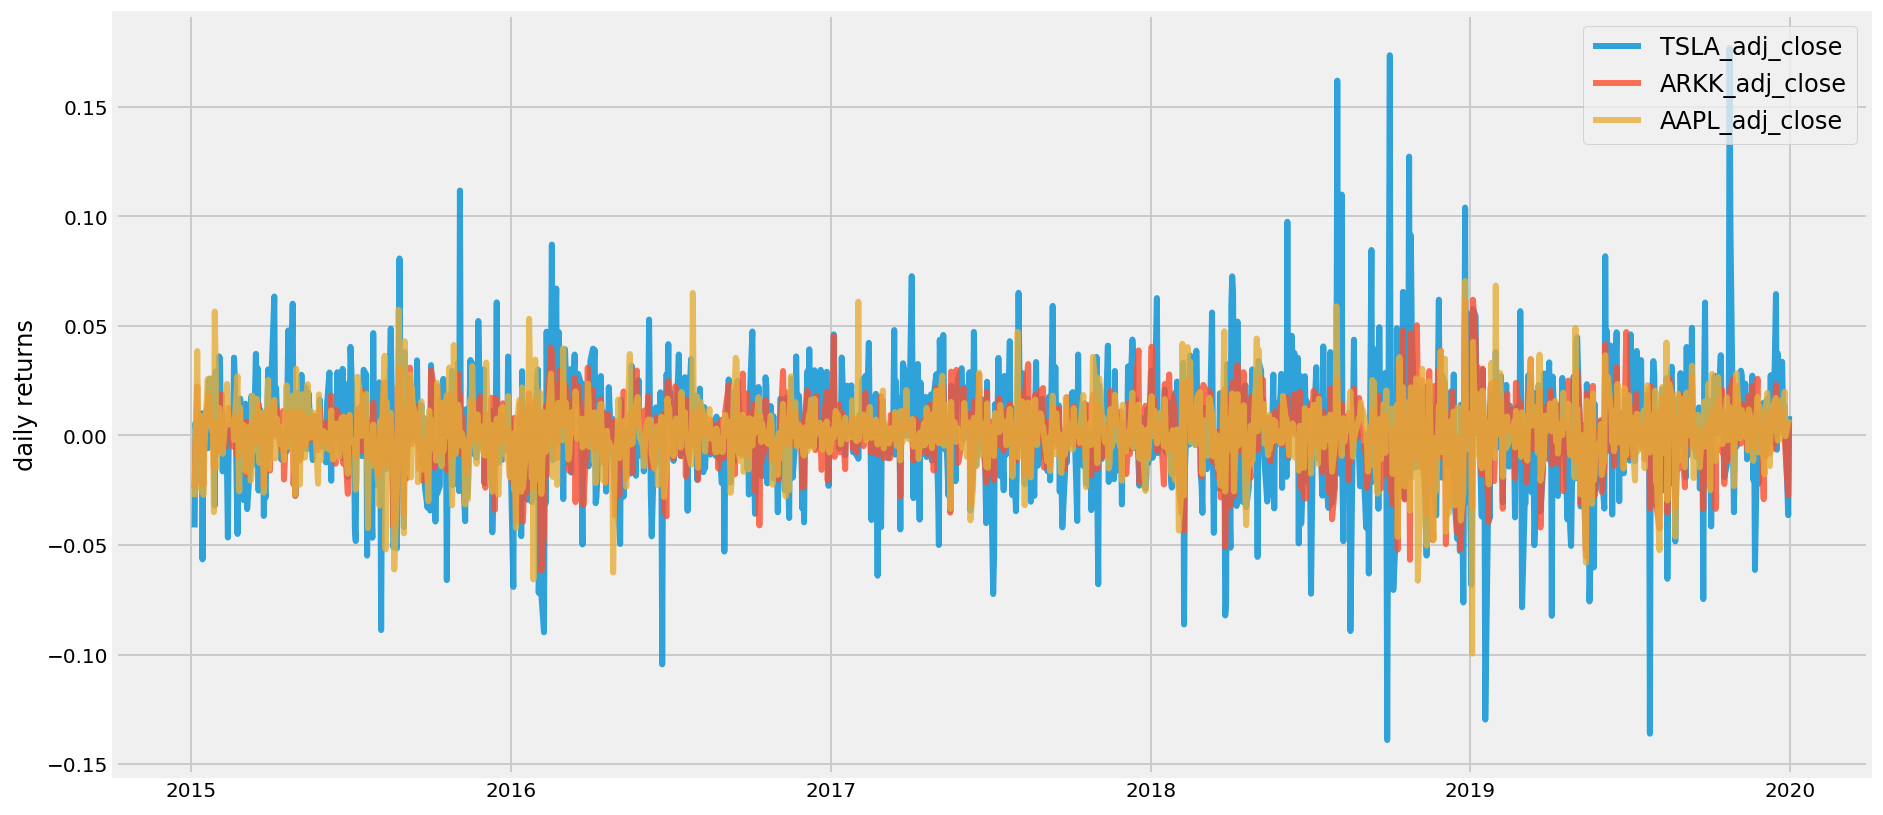

In [222]:
plot_daily_adj_returns_perc_change(df)

# Portfolio Optimization

In [223]:
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()

In [224]:
pd.DataFrame(mu)

,0
TSLA_adj_close,0.138219
ARKK_adj_close,0.216874
AAPL_adj_close,0.239923


In [225]:
S

,TSLA_adj_close,ARKK_adj_close,AAPL_adj_close
TSLA_adj_close,0.200495,0.051432,0.032770
ARKK_adj_close,0.051432,0.058357,0.031898
AAPL_adj_close,0.032770,0.031898,0.062281


## Efficient Frontier Optimisation

In [226]:
# optimises for maximal Sharpe ratio (a.k.a the tangency portfolio)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 23.0%
Annual volatility: 21.6%
Sharpe Ratio: 0.97
Optimal Weights: 
{
    "TSLA_adj_close": 0.0,
    "ARKK_adj_close": 0.4445922690401582,
    "AAPL_adj_close": 0.5554077309598421
}


In [227]:
# optimises for minimum volatility
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 22.6%
Annual volatility: 21.4%
Sharpe Ratio: 0.96
Optimal Weights: 
{
    "TSLA_adj_close": 0.0212718243460595,
    "ARKK_adj_close": 0.5161638826043291,
    "AAPL_adj_close": 0.4625642930496114
}


In [228]:
# optimises for minimum volatility, add L2 regularisation to increase the number of nonzero weights. 
ef = EfficientFrontier(mu, S)
ef.add_objective(L2_reg, gamma=2) #adds a (convex) objective to the optimisation problem
weights = ef.min_volatility()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 20.0%
Annual volatility: 24.5%
Sharpe Ratio: 0.73
Optimal Weights: 
{
    "TSLA_adj_close": 0.3174899792368109,
    "ARKK_adj_close": 0.3401246003872266,
    "AAPL_adj_close": 0.3423854203759626
}


In [229]:
# Calculate the ‘Markowitz portfolio’, minimising volatility for a given target return.
ef = EfficientFrontier(mu, S)
weights = ef.efficient_return(target_return=0.23, market_neutral=False)
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 23.0%
Annual volatility: 21.6%
Sharpe Ratio: 0.97
Optimal Weights: 
{
    "TSLA_adj_close": 0.0,
    "ARKK_adj_close": 0.4305230036185274,
    "AAPL_adj_close": 0.5694769963814726
}


In [230]:
# Maximise return for a target risk.
ef = EfficientFrontier(mu, S)
weights = ef.efficient_risk(target_volatility=0.3, market_neutral=False)
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 24.0%
Annual volatility: 25.0%
Sharpe Ratio: 0.88
Optimal Weights: 
{
    "TSLA_adj_close": 1.494557e-10,
    "ARKK_adj_close": 2.5862878e-09,
    "AAPL_adj_close": 0.9999999972643296
}


## Critical Line Algorithm (CLA)

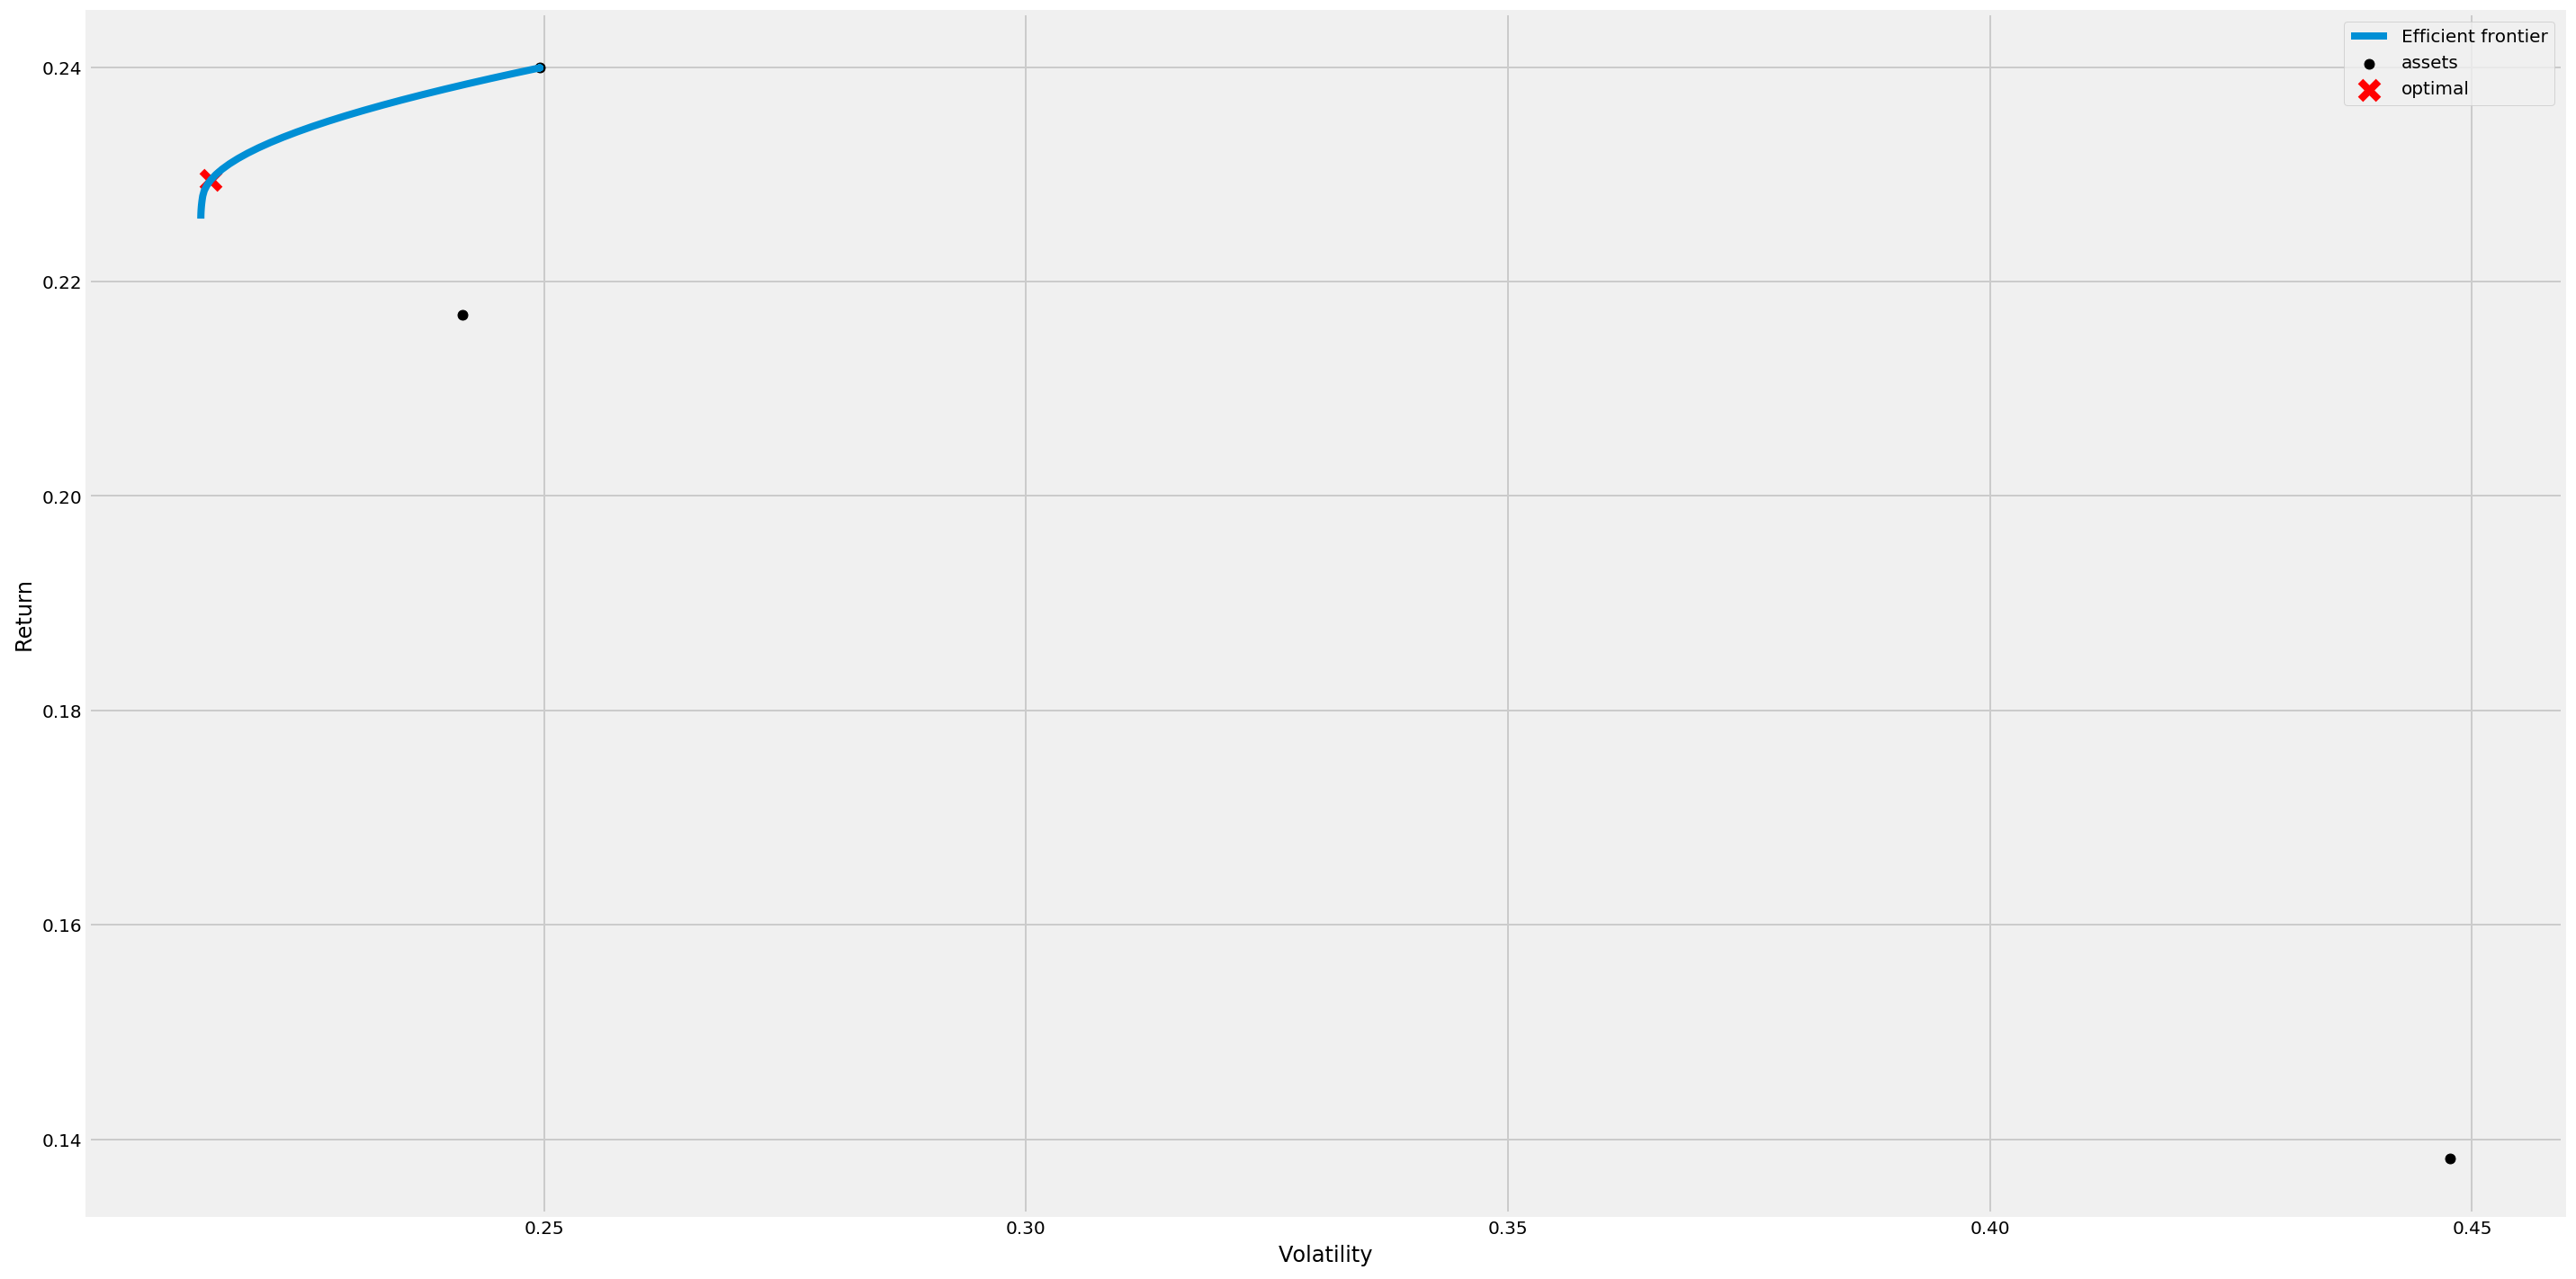

Expected annual return: 22.9%
Annual volatility: 21.5%
Sharpe Ratio: 0.97
Optimal Weights: 
{
    "TSLA_adj_close": 3.029616684626041e-18,
    "ARKK_adj_close": 0.45249425152750633,
    "AAPL_adj_close": 0.547505748472494
}


In [231]:
cla = CLA(mu, S, weight_bounds=(0, 1))
weights = cla.max_sharpe()
plot_efficient_frontier(cla)
expected_return, volatility, sharpe_ratio = cla.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

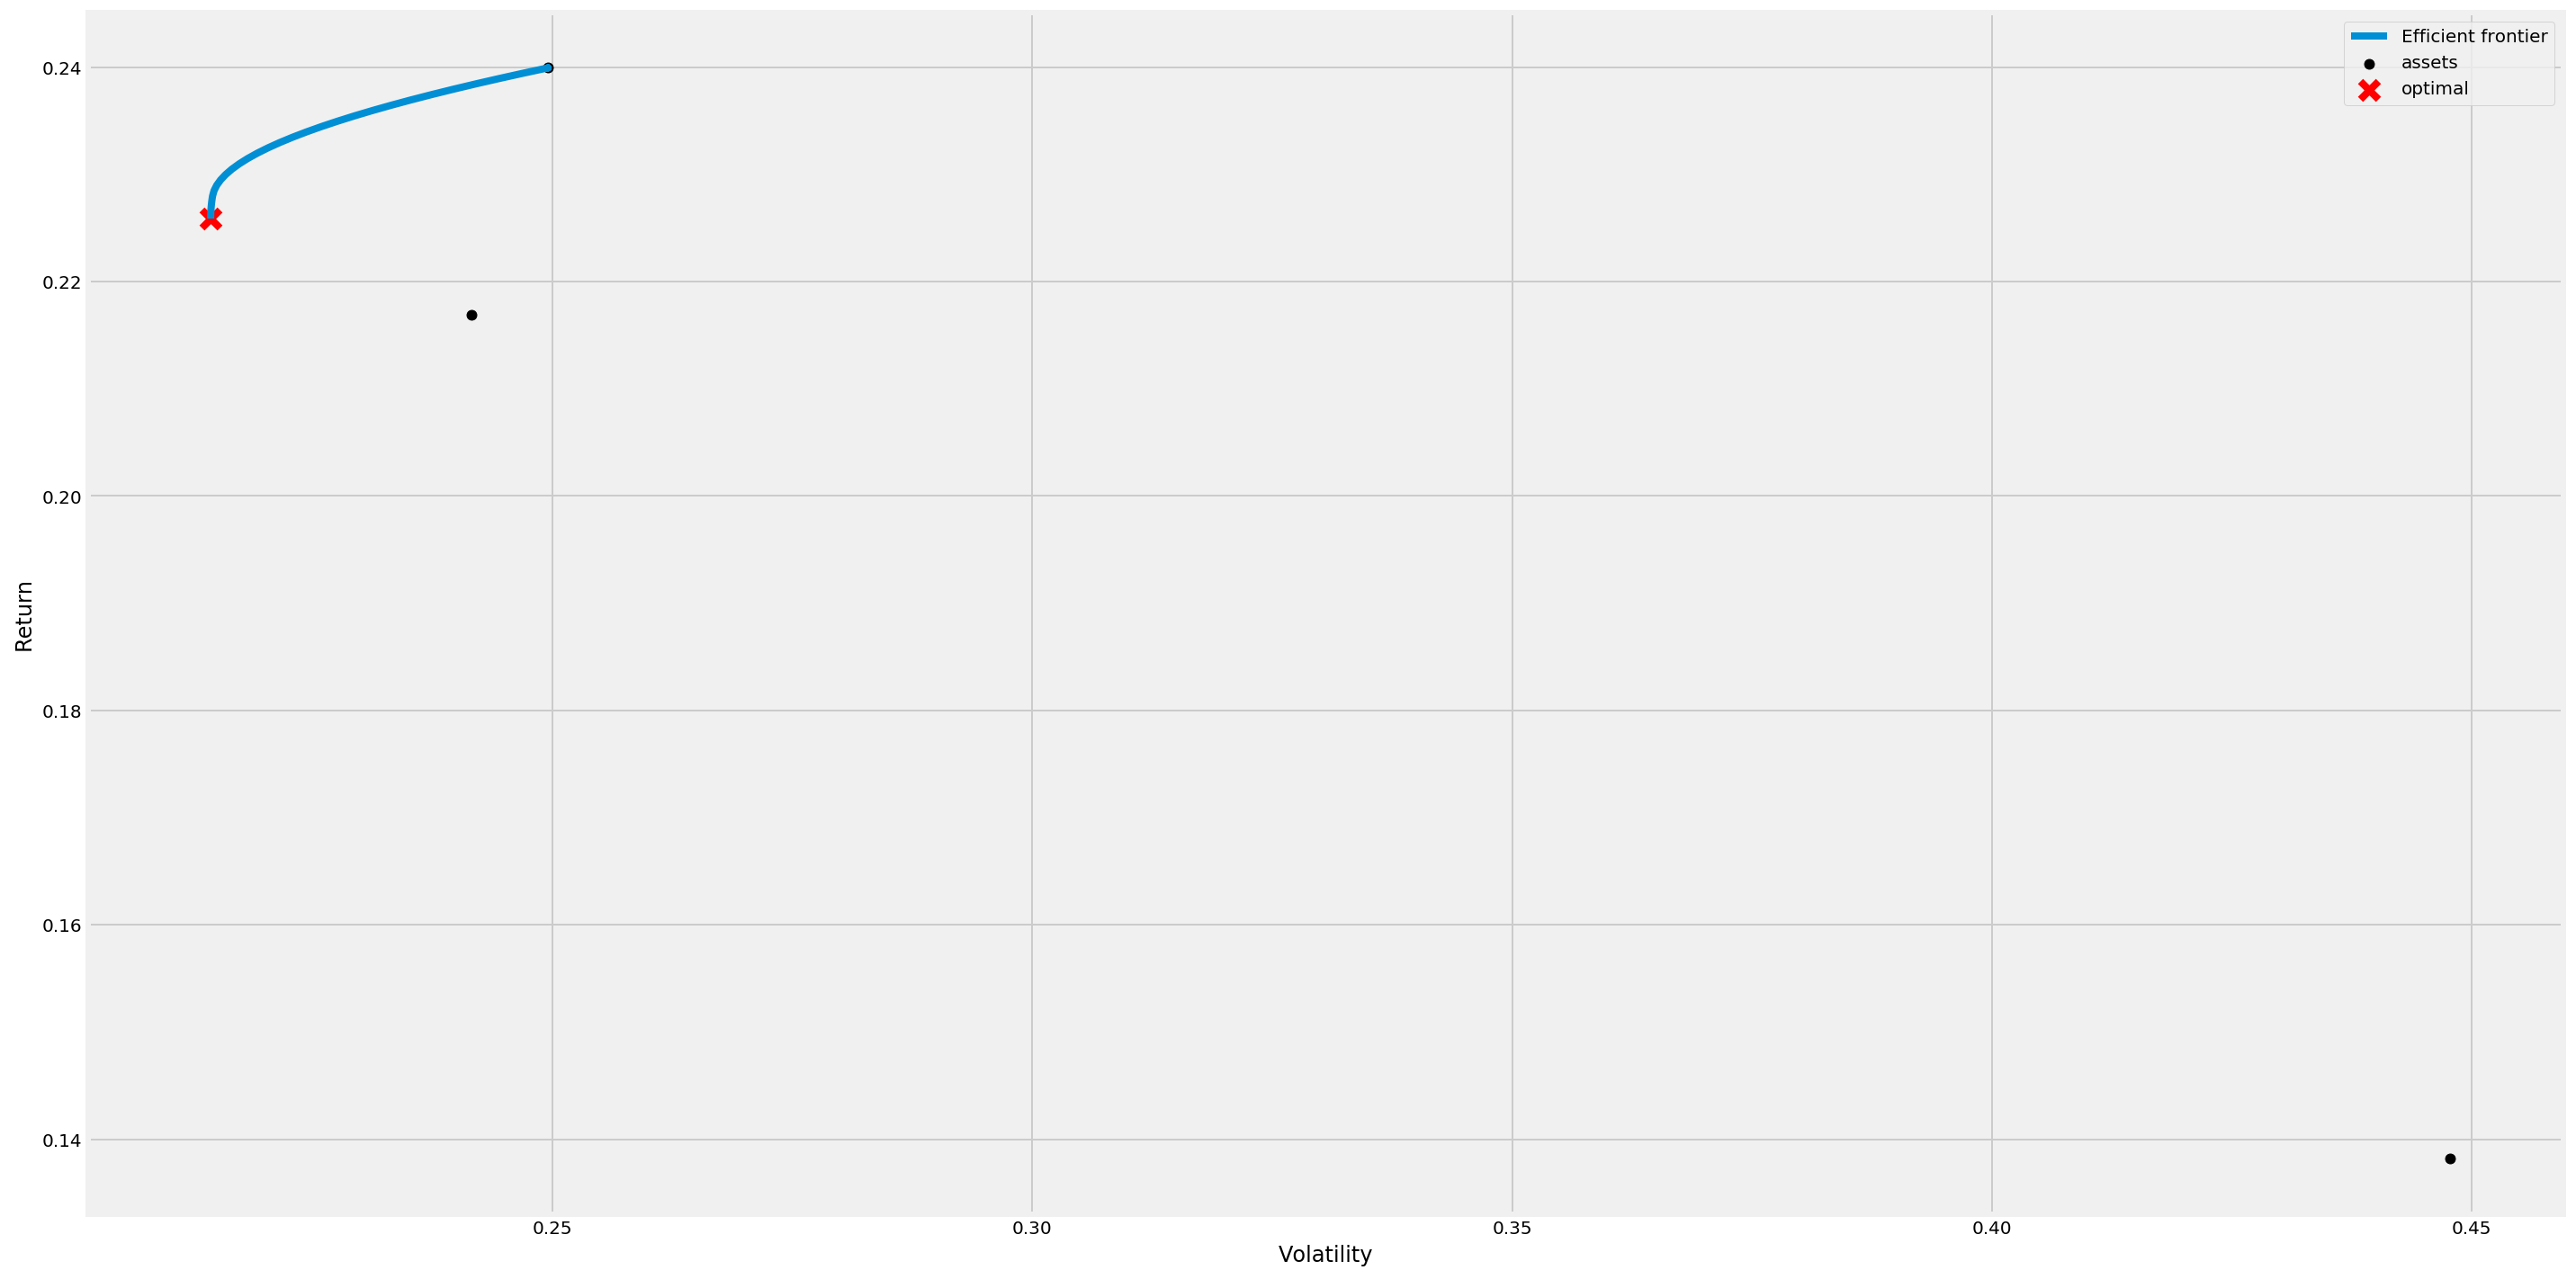

Expected annual return: 22.6%
Annual volatility: 21.4%
Sharpe Ratio: 0.96
Optimal Weights: 
{
    "TSLA_adj_close": 0.021271824346059478,
    "ARKK_adj_close": 0.5161638826043291,
    "AAPL_adj_close": 0.4625642930496116
}


In [232]:
cla = CLA(mu, S, weight_bounds=(0, 1))
weights = cla.min_volatility()
plot_efficient_frontier(cla)
expected_return, volatility, sharpe_ratio = cla.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

# Portfolio Allocation

In this section, we generate a portfolio allocation using the optimal weights. To do that, we post-process the optimal weights using methods:
- Simple Greedy Algorithm
- Integer Programming

In [233]:
# optimises for maximal Sharpe ratio (a.k.a the tangency portfolio)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 23.0%
Annual volatility: 21.6%
Sharpe Ratio: 0.97
Optimal Weights: 
{
    "TSLA_adj_close": 0.0,
    "ARKK_adj_close": 0.4445922690401582,
    "AAPL_adj_close": 0.5554077309598421
}


In [236]:
total_portfolio_value = 10000
latest_prices = get_latest_prices(df_all)
print(f"Latest prices:\n{latest_prices}\n")

Latest prices:
TSLA_adj_close    388.040009
ARKK_adj_close     90.790001
AAPL_adj_close    108.860001
Name: 2020-10-30 00:00:00, dtype: float64



In [237]:
# Simple Greedy Algorithm
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=total_portfolio_value)
allocation, leftover = da.greedy_portfolio(verbose=True)
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Funds remaining: 90.22
AAPL_adj_close: allocated 0.560, desired 0.555
ARKK_adj_close: allocated 0.440, desired 0.445
TSLA_adj_close: allocated 0.000, desired 0.000
Allocation has RMSE: 0.004
Discrete allocation: {'AAPL_adj_close': 51, 'ARKK_adj_close': 48}
Funds remaining: $90.22


In [238]:
# Integer Programming
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=total_portfolio_value)
allocation, leftover = da.lp_portfolio(verbose=True)
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Funds remaining: 90.22
TSLA_adj_close: allocated 0.000, desired 0.000
ARKK_adj_close: allocated 0.440, desired 0.445
AAPL_adj_close: allocated 0.560, desired 0.555
Allocation has RMSE: 0.004
Discrete allocation: {'ARKK_adj_close': 48, 'AAPL_adj_close': 51}
Funds remaining: $90.22


# Backtest on real-data

We define the YTD as the **backtesting period**. *YTD, Year-to-Date, is the period of time beginning the first day of the current calendar year or fiscal year up to the current date.*

In [258]:
# initial parameters
initial_portfolio_value = 100000
start_date = "2020-01-01"
end_date = "2020-11-01"
a = datetime.strptime(start_date, "%Y-%m-%d")
b = datetime.strptime(end_date, "%Y-%m-%d")
investment_horizon = (b - a).days

In [259]:
df_tsla = get_stock_data("TSLA", start_date, end_date)
df_arkk = get_stock_data("ARKK", start_date, end_date)
df_aapl = get_stock_data("AAPL", start_date, end_date)
df_tsla.head(1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
dt,,,,,
2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500


## Based on Max Sharpe Weights

In [260]:
# optimises for maximal Sharpe ratio (a.k.a the tangency portfolio)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 23.0%
Annual volatility: 21.6%
Sharpe Ratio: 0.97
Optimal Weights: 
{
    "TSLA_adj_close": 0.0,
    "ARKK_adj_close": 0.4445922690401582,
    "AAPL_adj_close": 0.5554077309598421
}


In [261]:
weights_and_init_cash_dict = {
    k: {
        'weight': v,
        'init_cash': v * initial_portfolio_value
    }
    for k, v in weights.items()
}

In [262]:
%%capture
df_tsla_backtest = backtest('buynhold',
                            df_tsla,
                            init_cash=weights_and_init_cash_dict['TSLA_adj_close']['init_cash'],
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

df_arkk_backtest = backtest('buynhold',
                            df_arkk,
                            init_cash=weights_and_init_cash_dict['ARKK_adj_close']['init_cash'],
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

df_aapl_backtest = backtest('buynhold',
                            df_aapl,
                            init_cash=weights_and_init_cash_dict['AAPL_adj_close']['init_cash'],
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

In [263]:
total_pnl = (df_tsla_backtest['pnl'] + df_arkk_backtest['pnl'] + df_aapl_backtest['pnl']).values[0]
final_portfolio_value = (df_tsla_backtest['final_value'] + df_arkk_backtest['final_value'] + df_aapl_backtest['final_value']).values[0]

net_returns_pct = total_pnl/initial_portfolio_value

print(f"Initial Portfolio Value @ {start_date}: ${initial_portfolio_value}")
print(f"Current Portfolio Value @ {end_date}: ${final_portfolio_value:.0f}")
print(f"Investment Horizon: {investment_horizon} days")
print(f"Portfolio Allocation and Initial Cash : {json.dumps(weights_and_init_cash_dict, indent=4)}")
print(f"Profit and Loss (percent): {net_returns_pct*100:.2f}%")


Initial Portfolio Value @ 2020-01-01: $100000
Current Portfolio Value @ 2020-11-01: $159184
Investment Horizon: 305 days
Portfolio Allocation and Initial Cash : {
    "TSLA_adj_close": {
        "weight": 0.0,
        "init_cash": 0.0
    },
    "ARKK_adj_close": {
        "weight": 0.4445922690401582,
        "init_cash": 44459.22690401582
    },
    "AAPL_adj_close": {
        "weight": 0.5554077309598421,
        "init_cash": 55540.77309598421
    }
}
Profit and Loss (percent): 59.18%


## Based on Minimum Volatility (L2 regularisation)

In [264]:
# optimises for minimum volatility, add L2 regularisation to increase the number of nonzero weights. 
ef = EfficientFrontier(mu, S)
ef.add_objective(L2_reg, gamma=2) #adds a (convex) objective to the optimisation problem
weights = ef.min_volatility()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
print(f"Optimal Weights: \n{json.dumps(weights, indent=4)}")

Expected annual return: 20.0%
Annual volatility: 24.5%
Sharpe Ratio: 0.73
Optimal Weights: 
{
    "TSLA_adj_close": 0.3174899792368109,
    "ARKK_adj_close": 0.3401246003872266,
    "AAPL_adj_close": 0.3423854203759626
}


In [265]:
weights_and_init_cash_dict = {
    k: {
        'weight': v,
        'init_cash': v * initial_portfolio_value
    }
    for k, v in weights.items()
}

In [266]:
%%capture
df_tsla_backtest = backtest('buynhold',
                            df_tsla,
                            init_cash=weights_and_init_cash_dict['TSLA_adj_close']['init_cash'],
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

df_arkk_backtest = backtest('buynhold',
                            df_arkk,
                            init_cash=weights_and_init_cash_dict['ARKK_adj_close']['init_cash'],
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

df_aapl_backtest = backtest('buynhold',
                            df_aapl,
                            init_cash=weights_and_init_cash_dict['AAPL_adj_close']['init_cash'],
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

In [267]:
total_pnl = (df_tsla_backtest['pnl'] + df_arkk_backtest['pnl'] + df_aapl_backtest['pnl']).values[0]
final_portfolio_value = (df_tsla_backtest['final_value'] + df_arkk_backtest['final_value'] + df_aapl_backtest['final_value']).values[0]

net_returns_pct = total_pnl/initial_portfolio_value

print(f"Initial Portfolio Value @ {start_date}: ${initial_portfolio_value}")
print(f"Current Portfolio Value @ {end_date}: ${final_portfolio_value:.0f}")
print(f"Investment Horizon: {investment_horizon} days")
print(f"Portfolio Allocation and Initial Cash : {json.dumps(weights_and_init_cash_dict, indent=4)}")
print(f"Profit and Loss (percent): {net_returns_pct*100:.2f}%")


Initial Portfolio Value @ 2020-01-01: $100000
Current Portfolio Value @ 2020-11-01: $251914
Investment Horizon: 305 days
Portfolio Allocation and Initial Cash : {
    "TSLA_adj_close": {
        "weight": 0.3174899792368109,
        "init_cash": 31748.997923681087
    },
    "ARKK_adj_close": {
        "weight": 0.3401246003872266,
        "init_cash": 34012.46003872266
    },
    "AAPL_adj_close": {
        "weight": 0.3423854203759626,
        "init_cash": 34238.54203759626
    }
}
Profit and Loss (percent): 151.91%


## Based on 100% all in TSLA 

In [268]:
%%capture
df_tsla_backtest = backtest('buynhold',
                            df_tsla,
                            init_cash=initial_portfolio_value,
                            buy_prop=1,
                            commission=0.008,
                            verbose=False)

In [269]:
total_pnl = df_tsla_backtest['pnl'].values[0]
final_portfolio_value = (df_tsla_backtest['final_value']).values[0]

net_returns_pct = total_pnl/initial_portfolio_value

print(f"Initial Portfolio Value @ {start_date}: ${initial_portfolio_value}")
print(f"Current Portfolio Value @ {end_date}: ${final_portfolio_value:.0f}")
print(f"Investment Horizon: {investment_horizon} days")
print(f"Portfolio Allocation and Initial Cash : {json.dumps(weights_and_init_cash_dict, indent=4)}")
print(f"Profit and Loss (percent): {net_returns_pct*100:.2f}%")


Initial Portfolio Value @ 2020-01-01: $100000
Current Portfolio Value @ 2020-11-01: $447095
Investment Horizon: 305 days
Portfolio Allocation and Initial Cash : {
    "TSLA_adj_close": {
        "weight": 0.3174899792368109,
        "init_cash": 31748.997923681087
    },
    "ARKK_adj_close": {
        "weight": 0.3401246003872266,
        "init_cash": 34012.46003872266
    },
    "AAPL_adj_close": {
        "weight": 0.3423854203759626,
        "init_cash": 34238.54203759626
    }
}
Profit and Loss (percent): 347.09%


In [273]:
df_tsla_backtest['maxdrawdown'][0]

60.605758153640984

In [276]:
df_tsla_backtest['maxdrawdownperiod'][0]

75

# Conclusion

- 3 configurations of portfolio weights:
    1. `'Max Sharpe'`
    2. `'Min Volatility w/ L2'`
    3. `'100% TSLA'`
    
    
- Observations:
    - `'Max Sharpe'` attained the lowest PNL @ 59.18%
    - `'Min Volatility w/ L2'` attained a significantly improved PNL @ 151.91%
    - `'100% TSLA'` attained a jaw-dropping PNL @ 347.09%
    - Markowitz’s method of optimization `'Max Sharpe'` assigned a weight of zero to TSLA. This is expected because this method is known to set many of the asset weights to be zero. A workaround is to introduce L2 regularization to the objective function, which is what we did to `'Min Volatility w/ L2'`.
    - We can speculate that TSLA's zero allocation is due of its high correlation with ARKK. (Afterall, ARKK has TSLA as the top holding.)
    - `'100% TSLA' strategy'` yielded a max drawdown of 60.6% YTD and a max drawdown period of 75 days. Some might violently disagree with this strategy as it defies all logic that points to diversification. To my defence, this is still a strategy worth evaluating.
    
    
- Notes:
    - When backtesting, we have to be careful about using in-sample data. In our case, we used 
        - 2015-01-01 to 2019-12-31 for optimization
        - 2020-01-01 to 2020-11-01 (YTD) for backtesting
    - `get_stock_data()` function retrieves the daily closing prices from yahoo finance. Adjusted closing prices are more appropriate because they account for cash and stock dividends.